## Evaluate LoRA-finetuned [paraphrase-mpnet-base-v2](https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2) model
The model which was finetuned using **Contrastive Learning** and `CoSENTLoss` is evaluated in this notebook.

In [1]:
from peft import AutoPeftModelForFeatureExtraction
import torch
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import pandas as pd
# from tqdm.auto import tqdm
import numpy as np
from scipy import spatial
from IPython.display import clear_output
import time

/export/home/co21btech11001/.conda/envs/nlp_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [2]:
df_ques_url_train = pd.read_pickle('../../data/questions_relevant_urls_chunks_train.pkl')
df_ques_url_test = pd.read_pickle('../../data/questions_relevant_urls_chunks_test.pkl')

print(df_ques_url_train.shape)
print(df_ques_url_test.shape)
df_ques_url_train.head(3)

(20000, 3)
(5000, 3)


,question,relevant_docs_urls,num_rel_chunks
0,What is (are) keratoderma with woolly hair ?,[https://ghr.nlm.nih.gov/condition/keratoderma...,5
1,How many people are affected by keratoderma wi...,[https://ghr.nlm.nih.gov/condition/keratoderma...,5
2,What are the genetic changes related to kerato...,[https://ghr.nlm.nih.gov/condition/keratoderma...,5


In [3]:
df_kb = pd.read_pickle('../../data/kb_chunks_emb_finetuned_lora_hard_negs.pkl')
print(df_kb.shape)
df_kb.head(3)

(33545, 3)


,doc_url,chunk_content,embedding
0,https://ghr.nlm.nih.gov/condition/keratoderma-...,keratoderma with woolly hair : medlineplus gen...,"[-0.0090271365, 0.06953493, -0.00038522395, 0...."
1,https://ghr.nlm.nih.gov/condition/keratoderma-...,"##ma, woolly hair, and a form of cardiomyopath...","[0.0030107216, 0.11447586, 0.002855658, 0.1539..."
2,https://ghr.nlm.nih.gov/condition/keratoderma-...,##pathy in people with this group of condition...,"[0.25198996, 0.2756908, 0.018188898, -0.008292..."


## Load finetuned model

In [4]:
model = AutoPeftModelForFeatureExtraction.from_pretrained("mpnet_peft_ft_cosent").to("cuda")
print("Loaded model")

Loaded model


In [5]:
model_name = "sentence-transformers/paraphrase-mpnet-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [6]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_embedding(sentences):
    inputs = tokenizer(sentences, padding="max_length", truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs.to(model.device))

    embeddings = mean_pooling(outputs, inputs['attention_mask']).cpu().numpy()
    return embeddings

In [7]:
sentences = ["Hello world", "Hi there"]
embeddings = get_embedding(sentences)
print(embeddings.shape)

(2, 768)


In [8]:
1 - spatial.distance.cosine(embeddings[0], embeddings[1])

np.float32(0.5296788)

In [9]:
df_kb['embedding'] = df_kb['chunk_content'].apply(
    lambda x: get_embedding([x])[0]
)
df_kb.to_pickle('../../data/kb_chunks_emb_finetuned_lora_cosent.pkl')

## Evaluate

In [10]:
def cos_sim(a, b):
    return 1 - spatial.distance.cosine(a, b)

def retrieve(ques, df_kb, model):
    question_embedding = get_embedding([ques])[0]
    # Copy the 'doc_url' and 'embedding' columns to a new dataframe
    df_kb_copy = df_kb[['doc_url', 'embedding']].copy()
     # Calculate the cosine similarity between the question embedding and all document embeddings
    df_kb_copy['cosine_similarity'] = df_kb_copy['embedding'].apply(
        lambda x: cos_sim(question_embedding, x))
    # Sort the dataframe by the cosine similarity in descending order
    df_kb_copy = df_kb_copy.sort_values(by='cosine_similarity', ascending=False)
    ret_urls = df_kb_copy['doc_url'].values
    return ret_urls

def recall_at_k(num_rel_chunks, relevant_docs_urls, top_retrieved_urls):
    """
    Procedure:
    - Among top_retrieved_urls, count the number of urls which are relevant
    - Divide this count by the total number of relevant urls
    """
    num_relevant = 0
    for url in top_retrieved_urls:
        if url in relevant_docs_urls:
            num_relevant += 1
    return num_relevant / num_rel_chunks

def mrr_at_k(relevant_docs_urls, top_retrieved_urls):
    """
    Procedure:
    - For each relevant_docs_urls, find the top index in top_retrieved_urls
    - Take the reciprocal of this index
    - Return the mean of these reciprocals
    """
    li = []
    for url in relevant_docs_urls:
        if url in top_retrieved_urls:
            # list.index returns the first occurrence of the url
            li.append(1 / (list(top_retrieved_urls).index(url) + 1))
    if len(li) == 0:
        return 0
    return np.mean(li)

In [11]:
def evaluate(df_ques_url):
    recall_1_li = []; mrr_1_li = []
    recall_3_li = []; mrr_3_li = []
    recall_10_li = []; mrr_10_li = []
    recall_100_li = []; mrr_100_li = []

    start_time = time.time()
    complete = 0
    total = len(df_ques_url)
    for _, row in df_ques_url.iterrows():
        ques = row['question']
        relevant_urls = row['relevant_docs_urls']
        num_rel_chunks = row['num_rel_chunks']

        retrieved_urls = retrieve(ques, df_kb, model)

        temp_recall_1 = recall_at_k(num_rel_chunks, relevant_urls, retrieved_urls[:1])
        temp_mrr_1 = mrr_at_k(relevant_urls, retrieved_urls[:1])
        temp_recall_3 = recall_at_k(num_rel_chunks, relevant_urls, retrieved_urls[:3])
        temp_mrr_3 = mrr_at_k(relevant_urls, retrieved_urls[:3])
        temp_recall_10 = recall_at_k(num_rel_chunks, relevant_urls, retrieved_urls[:10])
        temp_mrr_10 = mrr_at_k(relevant_urls, retrieved_urls[:10])
        temp_recall_100 = recall_at_k(num_rel_chunks, relevant_urls, retrieved_urls[:100])
        temp_mrr_100 = mrr_at_k(relevant_urls, retrieved_urls[:100])

        recall_1_li.append(temp_recall_1); mrr_1_li.append(temp_mrr_1)
        recall_3_li.append(temp_recall_3); mrr_3_li.append(temp_mrr_3)
        recall_10_li.append(temp_recall_10); mrr_10_li.append(temp_mrr_10)
        recall_100_li.append(temp_recall_100); mrr_100_li.append(temp_mrr_100)

        complete += 1
        percent_comp = (complete/total)*100
        clear_output(wait=True)
        print(f"Completed: {complete}/{total}: ({percent_comp:.2f}%)")

    end_time = time.time()
    time_taken = end_time - start_time
    print(f"Time taken: {time_taken:.2f} seconds")

    return recall_1_li, mrr_1_li, recall_3_li, mrr_3_li, recall_10_li, mrr_10_li, recall_100_li, mrr_100_li

def print_plot_results(df_ques_url):
    recall_1, mrr_1, recall_3, mrr_3, \
    recall_10, mrr_10, recall_100, mrr_100 = evaluate(df_ques_url)

    recall_1_score = np.mean(recall_1); mrr_1_score = np.mean(mrr_1)
    recall_3_score = np.mean(recall_3); mrr_3_score = np.mean(mrr_3)
    recall_10_score = np.mean(recall_10); mrr_10_score = np.mean(mrr_10)
    recall_100_score = np.mean(recall_100); mrr_100_score = np.mean(mrr_100)

    print(f"Recall@1: {recall_1_score:.4f}")
    print(f"Recall@3: {recall_3_score:.4f}")
    print(f"Recall@10: {recall_10_score:.4f}")
    print(f"Recall@100: {recall_100_score:.4f}")
    print()
    print(f"MRR@1: {mrr_1_score:.4f}")
    print(f"MRR@3: {mrr_3_score:.4f}")
    print(f"MRR@10: {mrr_10_score:.4f}")
    print(f"MRR@100: {mrr_100_score:.4f}")

    # Plot recall scores on histograms
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax[0, 0].hist(recall_1, bins=10, color='r', alpha=0.7)
    ax[0, 0].set_title('Recall@1')
    ax[0, 1].hist(recall_3, bins=10, color='g', alpha=0.7)
    ax[0, 1].set_title('Recall@3')
    ax[1, 0].hist(recall_10, bins=10, color='b', alpha=0.7)
    ax[1, 0].set_title('Recall@10')
    ax[1, 1].hist(recall_100, bins=10, color='y', alpha=0.7)
    ax[1, 1].set_title('Recall@100')
    plt.show()

Completed: 20000/20000: (100.00%)
Time taken: 8870.88 seconds
Recall@1: 0.2206
Recall@3: 0.4172
Recall@10: 0.5406
Recall@100: 0.6495

MRR@1: 0.8858
MRR@3: 0.9154
MRR@10: 0.9183
MRR@100: 0.9183


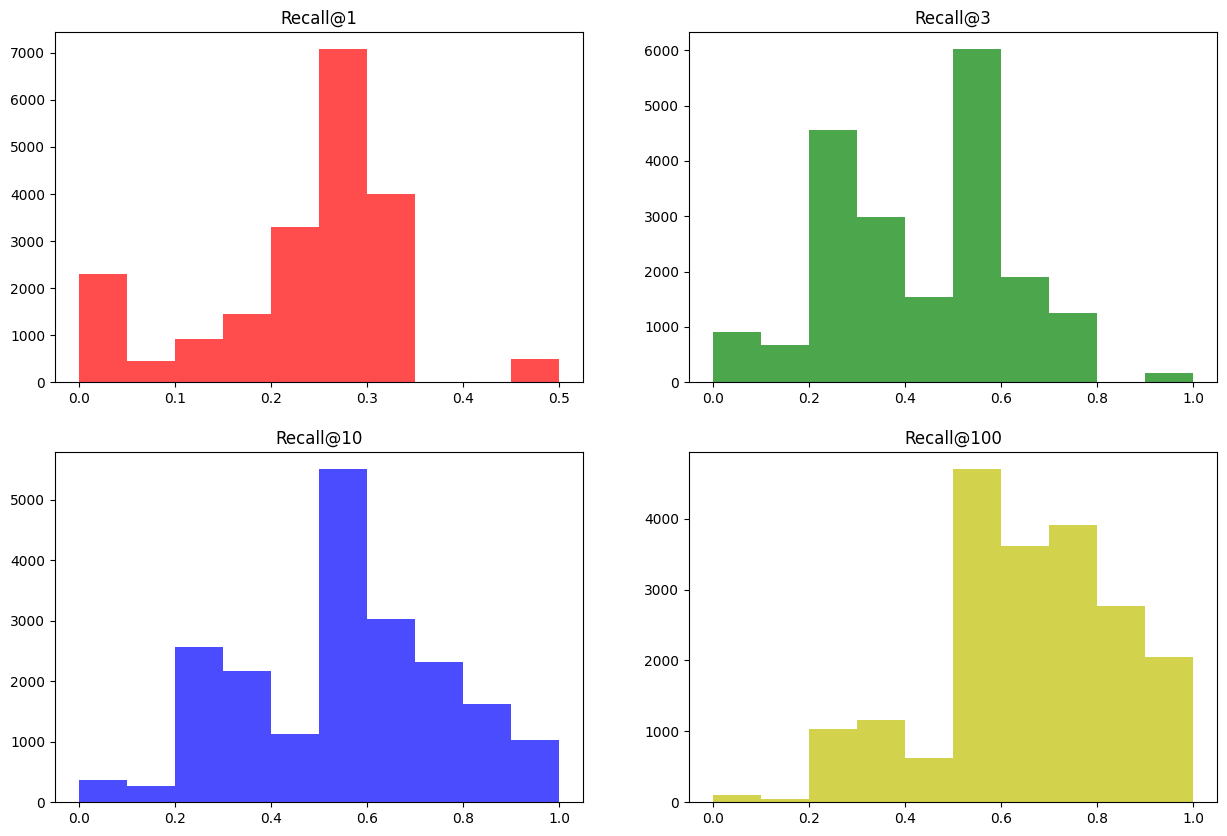

In [12]:
print_plot_results(df_ques_url_train)

Completed: 5000/5000: (100.00%)
Time taken: 2197.15 seconds
Recall@1: 0.2207
Recall@3: 0.3931
Recall@10: 0.4902
Recall@100: 0.6020

MRR@1: 0.8532
MRR@3: 0.8889
MRR@10: 0.8964
MRR@100: 0.8972


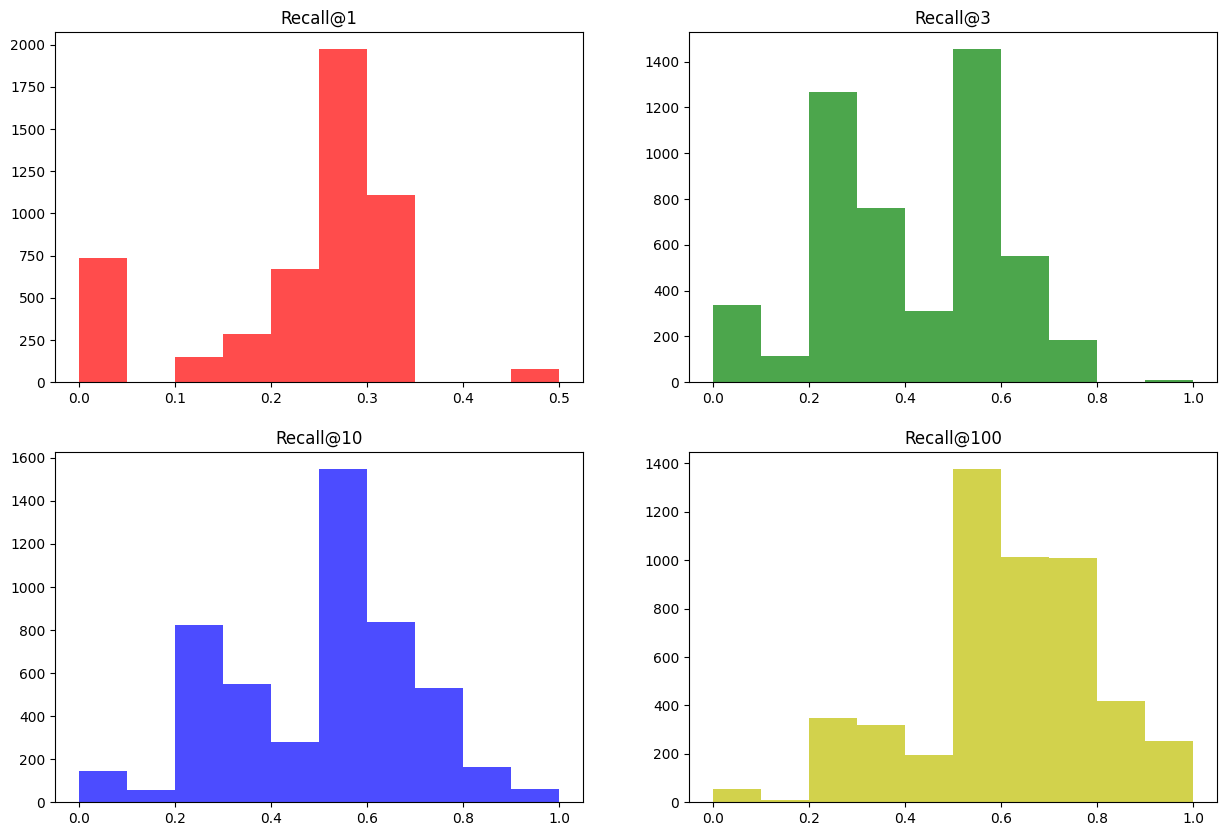

In [13]:
print_plot_results(df_ques_url_test)